In [1]:
#importing the necessary libraries

import os
import cv2
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.python.client import device_lib
from keras.models import Model
from keras import layers, models
from keras.mixed_precision import set_global_policy
from keras.backend import clear_session
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import json
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import gc
from keras.backend import clear_session

In [2]:
#Organizing Pathes

# Define paths
base_dir = Path.cwd().parent
dataset_dir = base_dir / "data\\facescrub"
results_dir = base_dir / "results\\facescrub"

os.makedirs(results_dir, exist_ok=True)

In [3]:
# Enable GPU memory growth before any TensorFlow operation
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(f"Error enabling memory growth: {e}")
else:
    print("No GPU detected.")

GPU memory growth enabled.


In [4]:
# Load preprocessed data
size = 45
X_train = np.load(results_dir / f"X{size}_train.npy", allow_pickle=True)
X_val = np.load(results_dir / f"X{size}_val.npy", allow_pickle=True)
X_test = np.load(results_dir / f"X{size}_test.npy", allow_pickle=True)
y_train = np.load(results_dir / "y_train.npy", allow_pickle=True)
y_val = np.load(results_dir / "y_val.npy", allow_pickle=True)
y_test = np.load(results_dir / "y_test.npy", allow_pickle=True)

X_train = tf.image.resize(X_train, [48, 48])
X_val = tf.image.resize(X_val, [48, 48])
X_test = tf.image.resize(X_test, [48, 48])

# Verify shapes
print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation set: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test set: {X_test.shape}, Labels: {y_test.shape}")

Training set: (30186, 48, 48, 3), Labels: (30186,)
Validation set: (6469, 48, 48, 3), Labels: (6469,)
Test set: (6469, 48, 48, 3), Labels: (6469,)


In [5]:
# Input dimensions
input_shape = X_train.shape[1:]
latent_dim = 128  # Latent dimensionality of the encoding space

In [6]:
# Encoder
inputs = tf.keras.Input(shape=input_shape, name="input_layer")
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

In [7]:
# Latent Space
x = layers.Flatten()(x)
latent = layers.Dense(latent_dim, activation='relu', name="latent_space")(x)

In [8]:
# Decoder
x = layers.Dense(6 * 6 * 128, activation='relu')(latent)
x = layers.Reshape((6, 6, 128))(x)
x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
outputs = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same', name="output_layer")(x)

In [9]:
# Autoencoder Model
autoencoder = models.Model(inputs, outputs, name="convolutional_autoencoder")

# Compile Model
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Summary
autoencoder.summary()

# Save the model structure
autoencoder.save(results_dir / "convolutional_autoencoder.h5")

gc.collect() # Garbage collection


Model: "convolutional_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 


 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 latent_space (Dense)        (None, 128)               589952    
                                                                 
 dense (Dense)               (None, 4608)              594432    
          

236

In [ ]:
# Train the autoencoder
history = autoencoder.fit(
    X_train,X_train,  # Input and target are the same for autoencoders
    epochs=50,
    batch_size=256,
    validation_data=(X_val, X_val)  # Validation data
)

# Evaluate reconstruction quality on the test set
test_loss, test_accuracy = autoencoder.evaluate(X_test, X_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the trained model
autoencoder.save(result_dir / "Convolutional_autoencoder.h5")

Epoch 1/50
118/118 [==============================] - 25s 200ms/step - loss: 0.0332 - accuracy: 0.9300 - val_loss: 0.0191 - val_accuracy: 0.9382
Epoch 2/50
118/118 [==============================] - 22s 189ms/step - loss: 0.0160 - accuracy: 0.9370 - val_loss: 0.0130 - val_accuracy: 0.9353
Epoch 3/50
118/118 [==============================] - 22s 190ms/step - loss: 0.0121 - accuracy: 0.9289 - val_loss: 0.0113 - val_accuracy: 0.9344
Epoch 4/50
118/118 [==============================] - 22s 186ms/step - loss: 0.0103 - accuracy: 0.9259 - val_loss: 0.0098 - val_accuracy: 0.9325
Epoch 5/50
118/118 [==============================] - 23s 196ms/step - loss: 0.0093 - accuracy: 0.9289 - val_loss: 0.0087 - val_accuracy: 0.9340
Epoch 6/50
118/118 [==============================] - 22s 190ms/step - loss: 0.0086 - accuracy: 0.9309 - val_loss: 0.0083 - val_accuracy: 0.9341
Epoch 7/50
118/118 [==============================] - 23s 198ms/step - loss: 0.0082 - accuracy: 0.9317 - val_loss: 0.0079 - val_ac

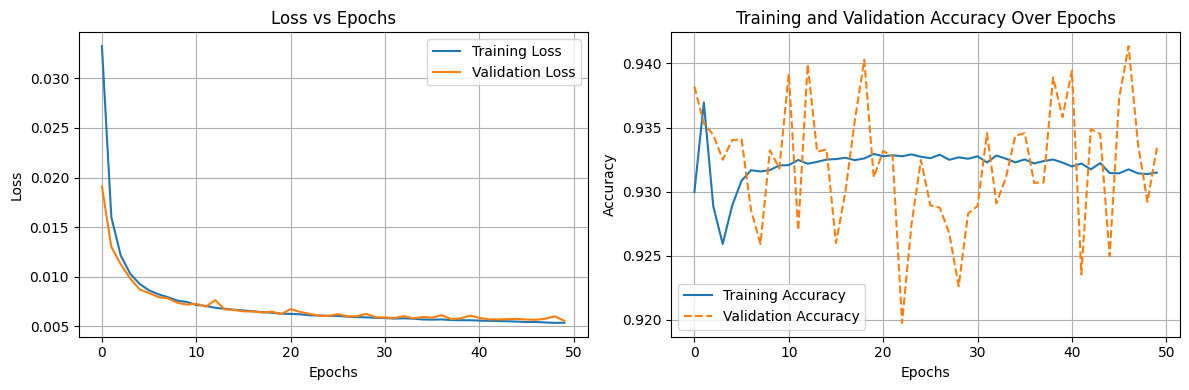

In [12]:
# Plot training loss
plt.figure(figsize=(12, 4))

# Plot Loss vs Epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


Loading model...
Testing the model...
203/203 [==============================] - 3s 11ms/step
Test Loss (MSE): 0.005578883


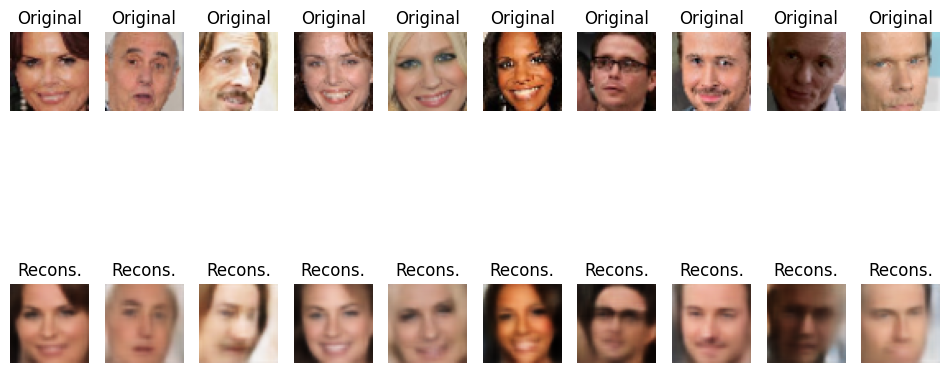

In [13]:
# Define the path to the saved model
model_path = os.path.join(results_dir, "Convolutional_trained_autoencoder.h5")

# Load the model
print("Loading model...")
#autoencoder = load_model(model_path)

# Test the model
print("Testing the model...")
reconstructed_images = autoencoder.predict(X_test)

# Compute MSE
test_loss = np.mean(np.square(X_test - reconstructed_images), axis=(1, 2, 3))  # MSE for each sample
print("Test Loss (MSE):", np.mean(test_loss))

# Visualize some reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(12, 6))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("Original")
    plt.axis("off")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i])
    plt.title("Recons.")
    plt.axis("off")
plt.show()

In [14]:
# Print all layer names to identify the correct one
for layer in autoencoder.layers:
    print(layer.name)


input_layer
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
flatten
latent_space
dense
reshape
conv2d_transpose
up_sampling2d
conv2d_transpose_1
up_sampling2d_1
conv2d_transpose_2
up_sampling2d_2
output_layer


In [15]:
# Extract the encoder from the autoencoder
encoder = models.Model(autoencoder.input, autoencoder.get_layer('latent_space').output)  # Adjust the layer name as per your model

In [16]:
# Extract features from the encoder
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)
scaler = StandardScaler()
encoded_train = scaler.fit_transform(encoded_train)
encoded_test = scaler.transform(encoded_test)

203/203 [==============================] - 1s 4ms/step


In [17]:
# Train SVM classifier
classifier = SVC(kernel='linear')
print("Training SVM Classifier...")
classifier.fit(encoded_train, y_train)

# Predict and evaluate
print("Predicting...")
y_pred = classifier.predict(encoded_test)
accuracy = accuracy_score(y_test, y_pred)
print("SVM Classifier Accuracy:", accuracy*100, "%")


Training SVM Classifier...
Predicting...
SVM Classifier Accuracy: 29.58726232802597 %


In [23]:
# Clear memory
clear_session()  # Clear Keras session
gc.collect()     # Run garbage collection
del autoencoder  # Delete the model object to free memory

In [ ]:
# Define a function to create the autoencoder with variable layers and nodes
from sklearn.model_selection import ParameterGrid


def create_autoencoder(input_shape, config):
    input_img = layers.Input(shape=input_shape)
    x = input_img

    # Encoder
    for i in range(config['num_layers']):
        x = layers.Conv2D(config['num_nodes'], (3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Record the shape before flattening
    encoder_output_shape = x.shape[1:]  # (height, width, channels)
    
    # Latent representation
    latent = layers.Flatten()(x)
    latent = layers.Dense(config['latent_dim'], activation='relu')(latent)
    
    # Decoder
    x = layers.Dense(np.prod(encoder_output_shape), activation='relu')(latent)
    x = layers.Reshape(encoder_output_shape)(x)
    for i in range(config['num_layers']):
        x = layers.Conv2D(config['num_nodes'], (3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling2D((2, 2))(x)
    
    decoded = layers.Conv2D(input_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Parameter grid for hyperparameter tuning
param_grid = {
    'num_layers': [2, 3, 4],   # Number of layers
    'num_nodes': [32, 64, 128], # Nodes per layer
    'latent_dim': [64, 128],    # Latent space dimension
}

# Generate all combinations of hyperparameters
grid = ParameterGrid(param_grid)

input_shape = X_train.shape[1:]  # Assumes data has already been preprocessed
reconstruction_losses = {}

# Iterate over each hyperparameter combination
for config in grid:
    print(f"Testing configuration: {config}")
    
    # Create model
    autoencoder = create_autoencoder(input_shape, config)
    
    # Train model
    history = autoencoder.fit(
        X_train, X_train,
        epochs=10,
        batch_size=64,
        validation_data=(X_val, X_val),
        verbose=1
    )
    
    # Evaluate reconstruction loss on validation data
    val_loss = autoencoder.evaluate(X_val, X_val, verbose=0)
    print(f"Validation Loss for {config}: {val_loss}")
    
    # Store validation loss for the configuration
    reconstruction_losses[str(config)] = val_loss
    # Clear memory
    clear_session()  # Clear Keras session
    gc.collect()     # Run garbage collection
    del autoencoder  # Delete the model object to free memory

# Find the best configuration
best_config = min(reconstruction_losses, key=reconstruction_losses.get)
print("\nBest Configuration:")
print(f"{best_config} with Loss: {reconstruction_losses[best_config]}")



Testing configuration: {'latent_dim': 64, 'num_layers': 2, 'num_nodes': 32}
Epoch 1/10
472/472 [==============================] - 22s 45ms/step - loss: 0.0202 - val_loss: 0.0125
Epoch 2/10
472/472 [==============================] - 20s 43ms/step - loss: 0.0117 - val_loss: 0.0113
Epoch 3/10
472/472 [==============================] - 20s 43ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 4/10
472/472 [==============================] - 20s 42ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 5/10
472/472 [==============================] - 22s 46ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 6/10
472/472 [==============================] - 20s 43ms/step - loss: 0.0101 - val_loss: 0.0101
Epoch 7/10
472/472 [==============================] - 20s 42ms/step - loss: 0.0100 - val_loss: 0.0101
Epoch 8/10
472/472 [==============================] - 22s 46ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 9/10
472/472 [==============================] - 21s 43ms/step - loss: 0.0098 - val_loss: 0.0099
Epoch 

TypeError: pivot() takes 1 positional argument but 4 were given

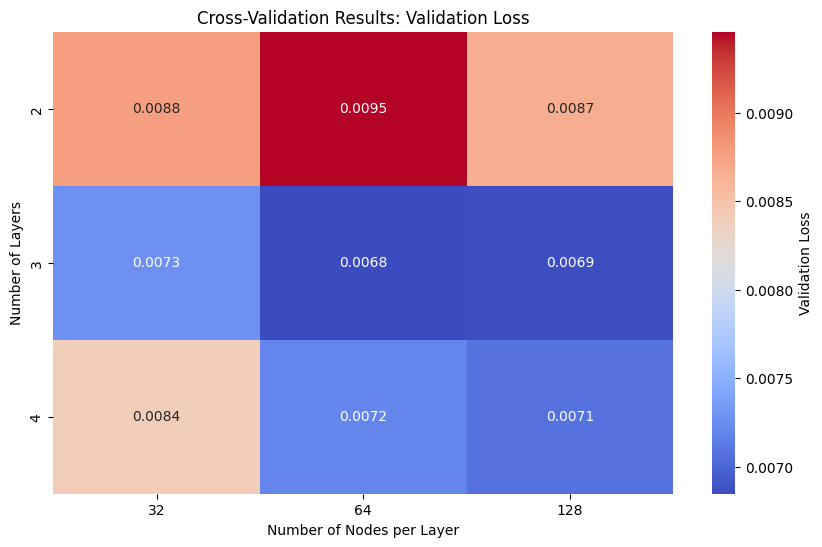

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the dictionary from the JSON file
with open(results_dir / 'reconstruction_losses.json', 'r') as f:
    reconstruction_losses = json.load(f)


# Visualization: Plotting validation losses for hyperparameter configurations
def plot_results(reconstruction_losses):
    # Convert the results dictionary to a DataFrame for easy plotting
    results_df = pd.DataFrame([
        {**eval(config), 'val_loss': loss} for config, loss in reconstruction_losses.items()
    ])
    
    # Group by 'num_layers' and 'num_nodes' and aggregate by taking the mean of 'val_loss'
    results_df = results_df.groupby(['num_layers', 'num_nodes'], as_index=False)['val_loss'].mean()
    
    # Pivot the DataFrame to visualize `num_layers` and `num_nodes` interaction
    pivot_table = results_df.pivot(index="num_layers", columns="num_nodes", values="val_loss")
    
    # Plot a heatmap for validation loss
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="coolwarm", cbar_kws={'label': 'Validation Loss'})
    plt.title("Cross-Validation Results: Validation Loss")
    plt.xlabel("Number of Nodes per Layer")
    plt.ylabel("Number of Layers")
    plt.show()

# Plot the results
plot_results(reconstruction_losses)

